In [1]:

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.reset_default_graph()
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import ops
tf.reset_default_graph()

In [2]:
# Start a graph session
sess = tf.Session()

In [3]:
# Load data
mnist = input_data.read_data_sets('MNIST_data/', one_hot=False)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
# Convert images into 28x28 (they are downloaded as 1x784)
X_train = np.array([np.reshape(x, (28,28)) for x in mnist.train.images])
X_test = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])
print(X_train.shape, X_test.shape)

# Not convert labels into one-hot encoded vectors
y_train = mnist.train.labels
y_test = mnist.test.labels
print(y_train.shape, y_test.shape)

# Z- score  or Gaussian Normalization
X_train = X_train - np.mean(X_train) / X_train.std()
X_test = X_test - np.mean(X_test) / X_test.std()

(55000, 28, 28) (10000, 28, 28)
(55000,) (10000,)


In [5]:
# Set model parameters
batch_size = 100
learning_rate = 0.005
evaluation_size = 500

image_width = X_train[0].shape[0]   # 28
image_height = X_train[0].shape[1]   # 28

target_size = int(np.max(y_train) + 1) # 10

num_channels = 1   # greyscale = 1 channel
generation = 500
eval_every = 5

conv1_features = 25
conv2_features = 50

max_pool_size1 = 2 # NxN window for 1st max pool layer
max_pool_size2 = 2 # NxN window for 2nd max pool layer

fully_connected_size1 = 100

In [6]:
X_input_shape = (batch_size, image_width, image_height, num_channels)   # 100 x 28 x 28 x 1

X_input = tf.placeholder(tf.float32, shape=X_input_shape)   # shape=(100, 28, 28, 1)
y_target = tf.placeholder(tf.int32, shape=(batch_size)) # 100

#=======================================================================================

eval_input_shape = (evaluation_size, image_width, image_height, num_channels)   # 500 x 28 x 28 x 1

eval_input = tf.placeholder(tf.float32, shape = eval_input_shape)
eval_target = tf.placeholder(tf.int32, shape = (evaluation_size)) # 500

In [7]:
# Convolutional layer variables
conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features], # shape = [4, 4, 1, 25]
                                                stddev = 0.1, dtype = tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype = tf.float32)) # shape = [25]

conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features],  # shape = [4, 4, 25, 50]
                                                stddev = 0.1, dtype = tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype = tf.float32)) # shape = [50]

In [10]:
# Fully connected variables
resulting_width = image_width // (max_pool_size1 * max_pool_size2) # 7
resulting_height = image_height // (max_pool_size1 * max_pool_size2) # 7

full1_input_size = resulting_width * resulting_height * conv2_features # 2450

#===============================================================================================
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1], # 2450 x 100
                          stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1,dtype=tf.float32)) # 100


full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size], # 100 x 10
                                               stddev=0.1, dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32)) # 10

In [11]:
# Initialize Model Operations
def my_conv_net(input_data):
    # First Conv-ReLU-MaxPool Layer
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='SAME') # filter = conv1_weight
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias)) # shape=(100, 28, 28, 25)
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1], # shape=(100, 14, 14, 25)
                              strides=[1, max_pool_size1, max_pool_size1, 1], padding='SAME')
    
    # Second Conv-ReLU-MaxPool Layer
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='SAME') # shape=(100, 14, 14, 50)
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias)) # shape=(100, 14, 14, 50)
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, max_pool_size2, max_pool_size2, 1], # shape=(100, 7, 7, 50)
                              strides=[1, max_pool_size2, max_pool_size2, 1], padding='SAME')
   
    # Transform Output into a 1xN layer for next fully connected layer
    final_conv_shape = max_pool2.get_shape().as_list()   # 100 x 7 x 7 x 50
  
    final_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]   # 7 x 7 x 50  shape = 2450
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], final_shape])   # shape=(100, 2450)
    #===================================================================================================
    
    # First Fully Connected Layer
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias)) # shape=(100, 100)
    
    # Second Fully Connected Layer
    final_model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias) # shape=(100, 10)
  
    return final_model_output

model_output = my_conv_net(X_input)
test_model_output = my_conv_net(eval_input)

In [17]:
# Declare Loss Function (softmax cross entropy)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))

In [18]:
# Create a prediction function
prediction = tf.nn.softmax(model_output)
test_prediction = tf.nn.softmax(test_model_output)

# Create accuracy function
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1) # (100, )
    num_correct = np.sum(np.equal(batch_predictions, targets)) # number of 2 numbers are the same
  
    return 100. * num_correct / batch_predictions.shape[0]

In [19]:
# Create an optimizer
my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
train_step = my_optimizer.minimize(loss)
    
# Initialize Variables
init = tf.global_variables_initializer()
sess.run(init)

In [20]:
import matplotlib.pyplot as plt
generations = 100
# Start training loop
train_loss = []
train_acc = []
test_acc = []
for i in range(generations):
    rand_index = np.random.choice(len(X_train), size=batch_size)
    rand_x = X_train[rand_index]
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = y_train[rand_index]
  
    train_dict = {X_input: rand_x, y_target: rand_y}
    
    sess.run(train_step, feed_dict=train_dict)
    
    temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    

    
    if (i+1) % eval_every == 0: # eval_every == 5
        eval_index = np.random.choice(len(X_test), size=evaluation_size)
        eval_x = X_test[eval_index]
        eval_x = np.expand_dims(eval_x, 3)

        eval_y = y_test[eval_index]
        
        test_dict = {eval_input: eval_x, eval_target: eval_y}
        
        test_preds = sess.run(test_prediction, feed_dict=test_dict)
        temp_test_acc = get_accuracy(test_preds, eval_y)
        
        # Record and print results
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
        
        acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))
        

Generation # 5. Train Loss: 2.34. Train Acc (Test Acc): 5.00 (11.80)
Generation # 10. Train Loss: 2.22. Train Acc (Test Acc): 25.00 (22.40)
Generation # 15. Train Loss: 2.15. Train Acc (Test Acc): 23.00 (26.20)
Generation # 20. Train Loss: 2.12. Train Acc (Test Acc): 46.00 (41.20)
Generation # 25. Train Loss: 2.06. Train Acc (Test Acc): 44.00 (51.40)
Generation # 30. Train Loss: 1.91. Train Acc (Test Acc): 46.00 (51.00)
Generation # 35. Train Loss: 1.83. Train Acc (Test Acc): 58.00 (62.60)
Generation # 40. Train Loss: 1.67. Train Acc (Test Acc): 60.00 (61.00)
Generation # 45. Train Loss: 1.48. Train Acc (Test Acc): 66.00 (69.20)
Generation # 50. Train Loss: 1.17. Train Acc (Test Acc): 76.00 (71.20)
Generation # 55. Train Loss: 1.03. Train Acc (Test Acc): 76.00 (72.60)
Generation # 60. Train Loss: 0.85. Train Acc (Test Acc): 78.00 (80.00)
Generation # 65. Train Loss: 0.65. Train Acc (Test Acc): 83.00 (80.00)
Generation # 70. Train Loss: 0.66. Train Acc (Test Acc): 82.00 (82.60)
Generati

[5 8 9 3 8 7]
[5 8 9 3 8 7]


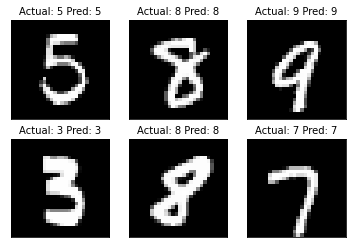

In [21]:

# Plot some samples
# Plot the 6 of the last batch results:
actuals = rand_y[0:6]
print(actuals)
predictions = np.argmax(temp_train_preds,axis=1)[0:6]
print(predictions)
images = np.squeeze(rand_x[0:6])

Nrows = 2
Ncols = 3
for i in range(6):
    plt.subplot(Nrows, Ncols, i+1)
    plt.imshow(np.reshape(images[i], [28,28]), cmap='Greys_r')
    plt.title('Actual: ' + str(actuals[i]) + ' Pred: ' + str(predictions[i]), fontsize=10)
    
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()